# Taller 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                              
import seaborn as sns
import geopandas as gpd

## Cargue de datos
Primero cargamos los datos, tanto del mapa usando el shape file, como de los datos que se desean representar

In [34]:
shapefile_path = "MGN2024_MPIO_POLITICO/MGN_ADM_MPIO_GRAFICO.shp"
map=gpd.read_file(shapefile_path)
map.head()

,dpto_ccdgo,mpio_ccdgo,mpio_cdpmp,dpto_cnmbr,mpio_cnmbr,mpio_crslc,mpio_tipo,mpio_narea,mpio_nano,shape_Leng,shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,MUNICIPIO,374.834005,2024,1.035380,0.030608,"POLYGON ((-75.66974 6.3736, -75.66965 6.3736, ..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,MUNICIPIO,507.141095,2024,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,MUNICIPIO,296.894050,2024,0.812183,0.024248,"POLYGON ((-76.08351 6.7505, -76.08325 6.75048,..."
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,MUNICIPIO,128.932153,2024,0.705200,0.010535,"POLYGON ((-75.0332 6.41586, -75.03313 6.41585,..."
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,MUNICIPIO,84.132477,2024,0.445533,0.006867,"POLYGON ((-75.67587 6.08561, -75.6754 6.08491,..."


In [35]:
map['dpto_ccdgo'] = map["dpto_ccdgo"].astype(int)

Se uso un dataset adicional para mapear los directorios de los encuestados con su respectivo municipio y departamento

In [36]:
# Carga TIC y diseño muestral
tic = pd.read_csv("Tecnologias de informacion y comunicacion.CSV",sep=";")
diseno = pd.read_csv("Variables diseno muestral.CSV",sep=";")
diseno.head()



,DIRECTORIO,SECUENCIA_P,ORDEN,MPIO,SEGMENTO,ESTRATO2020,F2,F_ETAPA1,FRES,FEX_C,BLOQUE
0,8219789,1,1,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
1,8219789,1,2,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
2,8219789,1,3,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
3,8219789,1,4,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008
4,8219789,1,5,8001,10143,898,1.0,478.63749,478.63749,651.298866,A00008


In [37]:
tic.head()

,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,ORDEN,FEX_C,P1910,P1911,P1912,P1084,P1710,...,P1080S4,P1080S5,P1080S6,P804,P805,P805S1,P805S2,P805S3,P805S4,P805S5
0,8219789,1,1,1,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
1,8219789,2,1,2,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
2,8219789,3,1,3,651.298866,5,2,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
3,8219789,4,1,4,651.298866,5,5,2,2,NaN,...,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
4,8219789,5,1,5,651.298866,5,5,5,1,NaN,...,1.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN


## Procesamiento de la variables

Las variables que decidi tomar son las preguntas P1048 que hace referencia a el acceso a internet que tiene el encuestado. Se representara en porcentajes de acuerdo al departamento.
La segundo fue la pregunta P1082 dice ¿tiene teléfono celular? Pudiendo responder 1= si y 2= no

In [ ]:
# Seleccion de solo las columnas necesarias
diseno = diseno[["DIRECTORIO", "MPIO"]]

# Une por DIRECTORIO
df = tic.merge(diseno, on="DIRECTORIO", how="left")

df["DPTO"] = df["MPIO"].astype(str).str[:2]
df["DPTO"] = df["DPTO"].astype(str).str.zfill(2)
map["dpto_ccdgo"] = map["dpto_ccdgo"].astype(str).str.zfill(2)
resumen = (
    df.groupby("DPTO")["P1084"]
      .apply(lambda x: (x == 1).mean() * 100)  # porcentaje
      .reset_index(name="porc_internet")
)

In [48]:
df['P1084'].isnull().sum()

np.int64(0)

In [46]:
print(df["P1082"].isnull().sum())
print(df["P1082S1"].isnull().sum())
print(df["P1082S2"].isnull().sum())

0
236986
236986


Para este caso se tomaran los valores nulos como personas que no tienen celular, esto de acuerdo a como estan hecha la encuesta

Luego para el caso de la pregunta P1082 se unen las dos pregunas que hacen parte a esta. P1082S1 dice, Teléfono celular convencional y P1082S2 dice, Teléfono celular inteligente (smartphone).

In [39]:
df = df.copy()
# Crear banderas binarias
df["convencional"] = ((df["P1082"] == 1) & (df["P1082S1"] == 1)).astype(int)
df["inteligente"]  = ((df["P1082"] == 1) & (df["P1082S2"] == 1)).astype(int)

# Si P1082 == 2 (no tiene celular) → se asegura que todo sea 0
df.loc[df["P1082"] == 2, ["convencional", "inteligente"]] = 0

# --- Resumir por departamento ---
resumen_cel = (
    df.groupby("DPTO")[["convencional", "inteligente"]]
      .mean()
      .reset_index()
)

# Pasar a porcentajes
resumen_cel[["convencional", "inteligente"]] *= 100

In [40]:
departamentos = map.dissolve(by="dpto_ccdgo", as_index=False)

## Graficas

Para graficar primero se hizo un merge para unir toda la informacion y usar este nuevo dataframe para graficar

In [41]:
gdf = departamentos.merge(resumen, left_on="dpto_ccdgo", right_on="DPTO", how="left")


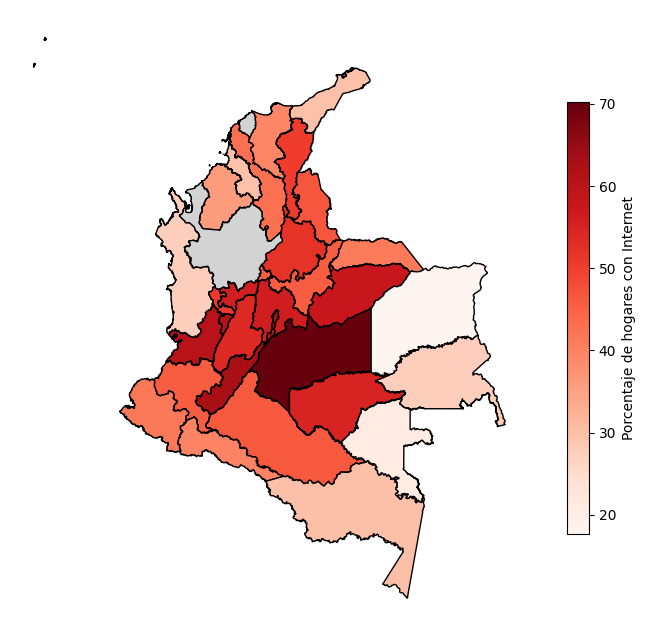

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

gdf.plot(
    column="porc_internet",
    cmap=plt.cm.Reds,
    legend=True,
    edgecolor="black",
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"
    },
    legend_kwds={
        "label": "Porcentaje de hogares con Internet",
        "orientation": "vertical",
        "shrink": 0.7
    }
)

ax.set_axis_off() 

plt.show()




---

### ¿Qué regiones concentran los valores más altos?

- Los valores más altos de acceso a Internet se concentran en los departamentos más urbanos y desarrollados, como Bogotá D.C., Antioquia, Valle del Cauca, Atlántico y Santander. Estos departamentos aparecen con los colores más intensos en el mapa, lo que indica un mayor porcentaje de hogares con acceso a Internet.

---

### ¿Se observan desigualdades territoriales?

- Sí, el mapa muestra desigualdades claras entre regiones. Los departamentos de la Amazonía, Orinoquía y algunos de la Costa Pacífica (como Vaupés, Guainía, Guaviare, Amazonas y Chocó) presentan porcentajes mucho menores de acceso a Internet, evidenciando una brecha territorial significativa.

---

### ¿Qué factores podrían explicar esas diferencias?

- **Nivel de urbanización:** Las zonas urbanas cuentan con mejor infraestructura y cobertura de servicios de Internet.
- **Desarrollo económico:** Los departamentos con mayor ingreso y desarrollo pueden costear más fácilmente el acceso a Internet.
- **Infraestructura:** En regiones rurales y apartadas, la conectividad es limitada o inexistente.
- **Educación:** Un mayor nivel educativo suele asociarse a mayor uso y acceso a tecnología.
- **Políticas públicas:** Algunas regiones han recibido más inversión en conectividad y tecnología.

---

**En resumen:**  
Las regiones más urbanas y desarrolladas concentran los valores más altos de acceso a Internet, mientras que las zonas rurales y apartadas presentan rezagos, reflejando desigualdades territoriales asociadas a factores económicos, de infraestructura y sociales.

In [43]:
gdf = gdf.merge(resumen_cel, left_on="dpto_ccdgo", right_on="DPTO", how="left")

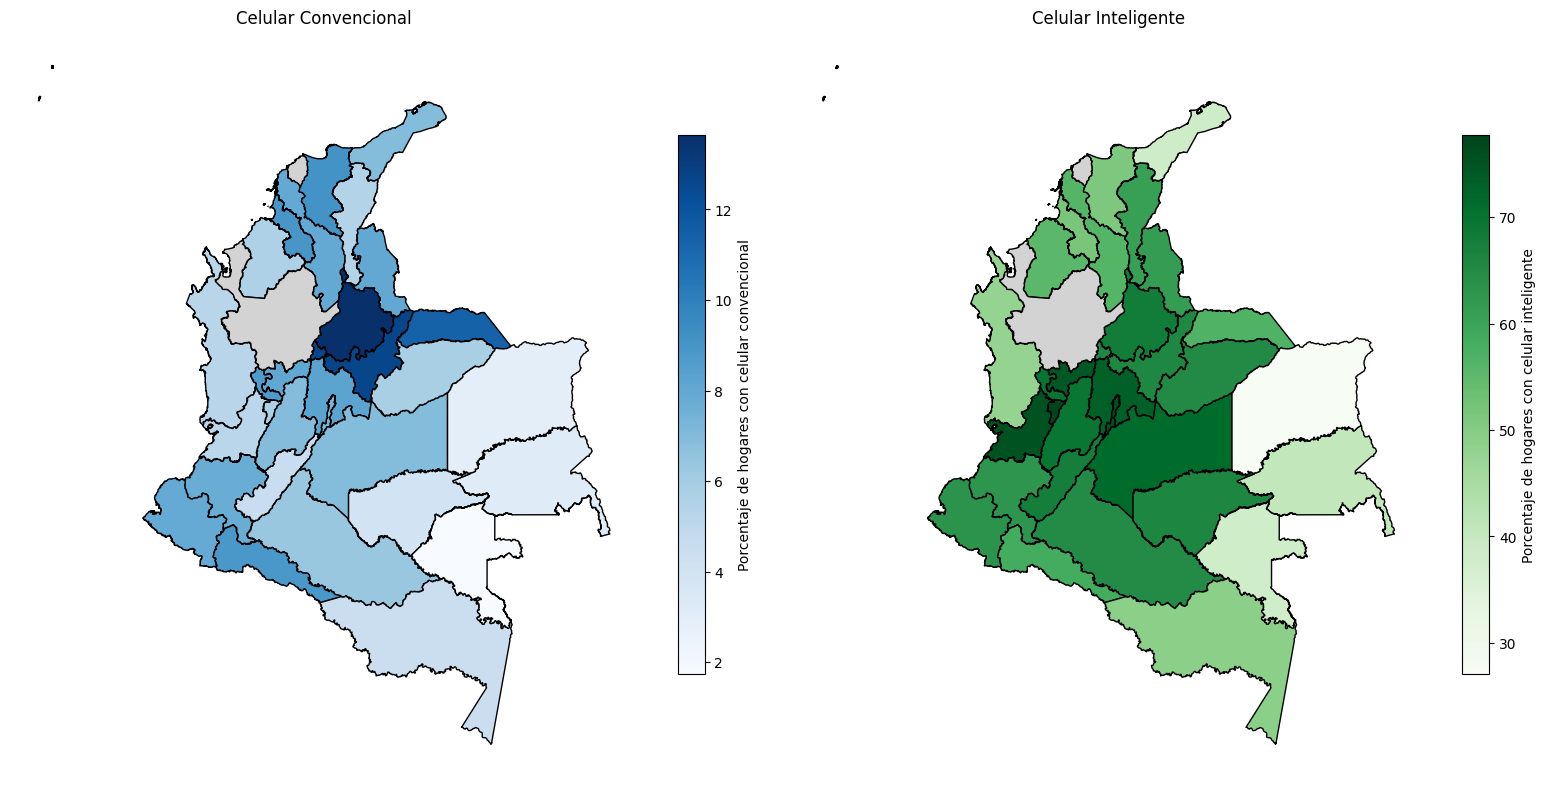

In [ ]:
# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mapa 1: Celular convencional
gdf.plot(
    column="convencional",
    cmap=plt.cm.Blues,
    legend=True,
    edgecolor="black",
    ax=axes[0],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"
    },
    legend_kwds={
        "label": "Porcentaje de hogares con celular convencional",
        "orientation": "vertical",
        "shrink": 0.7
    }
)
axes[0].set_title("Celular Convencional")
axes[0].set_axis_off()

# Mapa 2: Celular inteligente
gdf.plot(
    column="inteligente",
    cmap=plt.cm.Greens,
    legend=True,
    edgecolor="black",
    ax=axes[1],
    missing_kwds={
        "color": "lightgrey",
        "label": "Sin datos"
    },
    legend_kwds={
        "label": "Porcentaje de hogares con celular inteligente",
        "orientation": "vertical",
        "shrink": 0.7
    }
)
axes[1].set_title("Celular Inteligente")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


---

### ¿Qué regiones concentran los valores más altos?

- **Celular convencional e inteligente:**  
  Los valores más altos se concentran en los departamentos más urbanos y desarrollados, como Bogotá D.C., Antioquia, Valle del Cauca, Atlántico y Santander. Estas regiones aparecen con los colores más intensos en ambos mapas, indicando un mayor porcentaje de hogares con acceso a celulares convencionales e inteligentes.

---

### ¿Se observan desigualdades territoriales?

- Sí, los mapas muestran desigualdades claras entre regiones.  
  Los departamentos de la Amazonía, Orinoquía y algunos de la Costa Pacífica (como Vaupés, Guainía, Guaviare, Amazonas y Chocó) presentan porcentajes mucho menores, evidenciando una brecha territorial en el acceso a tecnología.

---

### ¿Qué factores podrían explicar esas diferencias?

- **Nivel de urbanización:** Las zonas urbanas tienen mejor infraestructura y cobertura de telecomunicaciones.
- **Desarrollo económico:** Los departamentos con mayor ingreso y desarrollo pueden costear más tecnología.
- **Infraestructura:** En regiones rurales y apartadas, la conectividad es limitada o inexistente.
- **Educación:** Un mayor nivel educativo suele asociarse a mayor uso y acceso a tecnología.
- **Políticas públicas:** Algunas regiones han recibido más inversión en conectividad y tecnología.

---

**En resumen:**  
Las regiones más urbanas y desarrolladas concentran los valores más altos, mientras que las zonas rurales y apartadas presentan rezagos, reflejando desigualdades territoriales asociadas a factores económicos, de infraestructura y sociales.